# Install relevant packages



In [1]:
!pip install transformers datasets yahoo_fin openai -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 8.1 

# Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import relevant modules from packages

In [ ]:
import pandas as pd
from datasets import load_dataset
from tqdm.auto import tqdm
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")

from google.colab import userdata
from openai import OpenAI

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY, max_retries=5)

from yahoo_fin import stock_info as si
import datetime
from ast import literal_eval
import matplotlib.pyplot as plt


timestamp = datetime.datetime.now().replace(microsecond=0).timestamp()
filename_stamp = str(int(timestamp))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Functions used for data cleaning

In [ ]:
def uncluster_tickers(data):
  # Store the tickers_mentioned string a list using literal_eval and add a column with these list.
  ticker_list = []
  for _, row in tqdm(data.iterrows(), total = data.shape[0]):
    ticker_list.append(literal_eval(row.tickers_mentioned))
  data['ticker_list'] = ticker_list

  # For each of the tickers found create a row containing the time, text, url, ticker
  unclustered_data = {'timestamp':[],'text':[],'url':[],'ticker':[], 'ticker_tweet': []}
  for _, row in tqdm(data.iterrows(), total = data.shape[0]):
    for i in range(len(row.ticker_list)):
      unclustered_data['timestamp'].append(row.timestamp)
      unclustered_data['text'].append(row.tweet_text)
      unclustered_data['url'].append(row.tweet_url)
      # Differentiate between the ticker used in yahoo_fin and the one found in the tweet, always store upper.
      unclustered_data['ticker_tweet'].append(row.ticker_list[i].upper())
      unclustered_data['ticker'].append(row.ticker_list[i].replace("$","").upper())

  data = pd.DataFrame.from_dict(unclustered_data)

  return data


In [ ]:
# Function to remove the tickers unfamiliar to yahoo finance
def remove_unknown_tickers(data):
  tickers = data.ticker.unique()
  missing_tickers = []
  for ticker in tqdm(tickers, total = len(tickers)):
    try:
      table = si.get_data(ticker, start_date='01-01-2022')
    except:
      missing_tickers.append(ticker)

  valid_ticker=[]
  for _, row in tqdm(data.iterrows(), total = data.shape[0]):
    if row.ticker in missing_tickers:
      valid_ticker.append(False)
    else:
      valid_ticker.append(True)
  data['valid_ticker'] = valid_ticker
  data = data[data.valid_ticker == True].dropna()
  data.reset_index(inplace=True, drop=True)
  return data

In [ ]:
# Create a prompt from the text and get the number of tokens
def create_prompt_and_tokenize(data, source):
  prompts = []
  for _, row in tqdm(data.iterrows(), total = data.shape[0]):
    prompts.append(f'Instruct: Given the {source} below, please indicate whether the price of the stock with ticker "{row.ticker}" will go up or down tomorrow. Only answer with UP or DOWN. \n Tweet: "{row.text}" \n\nOutput:')
  data['prompt'] = prompts

  tensor_lengths = []
  for _, row in tqdm(data.iterrows(), total = data.shape[0]):
    tens = tokenizer.encode(row.prompt, add_special_tokens=False ,return_tensors="pt")
    tensor_lengths.append(tens.shape[1])
  data['token_count'] = tensor_lengths

  return data

In [ ]:
# the yahoo_fin package can sometimes throw a timestamp error, run code again to fix this

# Get the behaviour of the stocks over the following 5 trading days with this function
def stock_behaviour(data):
  # Sort the tweets by tickers for efficiency in collecting pricing data
  data = data.sort_values('ticker')
  data.reset_index(inplace=True, drop=True)
  global ticker

  # Get the price data for the five next trading days
  first_row = data.iloc[0]
  price_movement = {'open':[],'close_1':[], 'close_2':[], 'close_3':[], 'close_4':[], 'close_5':[]}
  ticker_table = si.get_data(first_row.ticker, start_date='01-01-2022')
  none_counter = 0

  for index, row in tqdm(data.iterrows(), total = data.shape[0]):
    if ticker_table.ticker[0].upper() != row.ticker:
      ticker = row.ticker
      ticker_table = si.get_data(row.ticker, start_date='01-01-2022')
    else:
      pass
    movement_table = ticker_table.loc[(row.timestamp + datetime.timedelta(days=1)).date():(row.timestamp + datetime.timedelta(days=20)).date()]
    movement_table = movement_table.dropna()
    # If there were no trades this is considered to no be valid data
    if sum(movement_table.volume) == 0:
      price_movement['open'].append(None)
      price_movement['close_1'].append(None)
      price_movement['close_2'].append(None)
      price_movement['close_3'].append(None)
      price_movement['close_4'].append(None)
      price_movement['close_5'].append(None)
      none_counter+=1
    # In the next 20 days there should be at least 5 days with valid trading data
    elif len(movement_table) >= 5:
      price_movement['open'].append(movement_table.open[0])
      price_movement['close_1'].append(movement_table.close[0])
      price_movement['close_2'].append(movement_table.close[1])
      price_movement['close_3'].append(movement_table.close[2])
      price_movement['close_4'].append(movement_table.close[3])
      price_movement['close_5'].append(movement_table.close[4])
    else:
      # If not enough data is avaialble it is considered to not be valid data
      price_movement['open'].append(None)
      price_movement['close_1'].append(None)
      price_movement['close_2'].append(None)
      price_movement['close_3'].append(None)
      price_movement['close_4'].append(None)
      price_movement['close_5'].append(None)
      none_counter+=1

  pricing_df = pd.DataFrame.from_dict(price_movement)
  data_priced = pd.concat([data, pricing_df], axis=1)
  data_priced = data_priced.dropna()
  data_priced.reset_index(inplace=True, drop=True)

  # Convert the pricing information to binary price movement ['UP','DOWN']
  data_priced['result_1'] = ["UP" if row.close_1 > row.open else "DOWN" for _, row in data_priced.iterrows()]
  data_priced['result_2'] = ["UP" if row.close_2 > row.open else "DOWN" for _, row in data_priced.iterrows()]
  data_priced['result_3'] = ["UP" if row.close_3 > row.open else "DOWN" for _, row in data_priced.iterrows()]
  data_priced['result_4'] = ["UP" if row.close_4 > row.open else "DOWN" for _, row in data_priced.iterrows()]
  data_priced['result_5'] = ["UP" if row.close_5 > row.open else "DOWN" for _, row in data_priced.iterrows()]

  data_priced['result_1_bin'] = [1 if row.close_1 > row.open else 0 for _, row in data_priced.iterrows()]
  data_priced['result_2_bin'] = [1 if row.close_2 > row.open else 0 for _, row in data_priced.iterrows()]
  data_priced['result_3_bin'] = [1 if row.close_3 > row.open else 0 for _, row in data_priced.iterrows()]
  data_priced['result_4_bin'] = [1 if row.close_4 > row.open else 0 for _, row in data_priced.iterrows()]
  data_priced['result_5_bin'] = [1 if row.close_5 > row.open else 0 for _, row in data_priced.iterrows()]

  return data_priced

In [ ]:
# function to check how balanced the dataset is
def balance_check(data):
  i=0
  for col_name in ['result_1', 'result_2', 'result_3', 'result_4', 'result_5']:
    i+=1
    grouped = data.groupby(col_name).text.count()
    print(f'{i} trading day after the tweet the count for "UP" is  {grouped["UP"]}, and for down is {grouped["DOWN"]}')

In [ ]:
# Use GPT-3.5 turbo to find the text with relevant information about the stock with the assigned ticker
def OpenAI_relevance_check(data, source):
  relevance = []
  for index, row in tqdm(data.iterrows(), total= data.shape[0]):
    instruction = f"Please indicate wether there is any relevant information about the stock with ticker {row.ticker} in the {source} below, please respond with True or False.\n"
    tweet = f"Tweet: {row.text}"
    prompt = instruction + tweet

    completion = client.chat.completions.create(
      model="gpt-3.5-turbo-0125",
      seed=42,
      max_tokens=1,
      messages=[
        {"role": "user", "content": prompt}]
    )
    response = completion.choices[0].message.content
    relevance.append(completion.choices[0].message.content.upper())
  data['relevance'] = relevance
  return data

# Twitter

In [ ]:
# Load the data from huggingface
dataset = load_dataset("StephanAkkerman/financial-tweets-stocks")
twitter_df = pd.DataFrame.from_dict(dataset['train'])
twitter_df.describe()

,timestamp,tweet_text,tweet_url,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned,category
count,14363,20899,22383,22383,22383,22383,22383,22383
unique,14363,19828,21904,3,15783,6264,4012,4
top,2023-11-15T09:36:42.028000+00:00,$DXY,http://pbs.twimg.com/media/FURnEP4WYBY45Ir.jpg,tweet,[],[],['$SPY'],stock_images
freq,1,70,19,21970,1520,1520,1520,15606


In [ ]:
# Drop rows with empty values in them
twitter_df = twitter_df.dropna()
twitter_df['timestamp'] = pd.to_datetime(twitter_df.timestamp, format='mixed')
twitter_df.describe()

,timestamp,tweet_text,tweet_url,tweet_type,price_of_ticker,change_of_ticker,tickers_mentioned,category
count,14363,14363,14363,14363,14363,14363,14363,14363
unique,NaN,13564,14223,3,11406,4502,2891,4
top,NaN,$DXY,https://twitter.com/user/status/16784346934804...,tweet,[None],[None],['$SPY'],stock_images
freq,NaN,70,4,13950,192,192,998,9651
mean,2022-12-09 21:02:45.553506560+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2021-12-27 16:59:17.621000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2022-08-05 11:36:26.362500096+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2022-12-06 14:15:39.140999936+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2023-04-05 14:45:49.876500224+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2023-11-15 09:36:42.028000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Filter on original tweets and only keep the stock related tweets
twitter_df = twitter_df[twitter_df['tweet_type']== 'tweet']
print(twitter_df.count())
twitter_df = twitter_df[(twitter_df['category']== 'stock_images') | (twitter_df['category']== 'stock_text')]
twitter_df.reset_index(inplace=True, drop=True)
print(twitter_df.count())

timestamp            13950
tweet_text           13950
tweet_url            13950
tweet_type           13950
price_of_ticker      13950
change_of_ticker     13950
tickers_mentioned    13950
category             13950
dtype: int64
timestamp            13054
tweet_text           13054
tweet_url            13054
tweet_type           13054
price_of_ticker      13054
change_of_ticker     13054
tickers_mentioned    13054
category             13054
dtype: int64


In [ ]:
# Uncluster the tweers
twitter_df = uncluster_tickers(twitter_df)

  0%|          | 0/13054 [00:00<?, ?it/s]

  0%|          | 0/13054 [00:00<?, ?it/s]

In [ ]:
twitter_df.count()

timestamp       20746
text            20746
url             20746
ticker          20746
ticker_tweet    20746
dtype: int64

In [ ]:
# Drop the tickers not known by yahoo_fin
twitter_df = remove_unknown_tickers(twitter_df)

  0%|          | 0/1731 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()
/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()
/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

  0%|          | 0/20746 [00:00<?, ?it/s]

In [ ]:
twitter_df.count()

timestamp       18395
text            18395
url             18395
ticker          18395
ticker_tweet    18395
valid_ticker    18395
dtype: int64

In [ ]:
# Create prompts
twitter_df = create_prompt_and_tokenize(twitter_df, 'tweet')

  0%|          | 0/18395 [00:00<?, ?it/s]

  0%|          | 0/18395 [00:00<?, ?it/s]

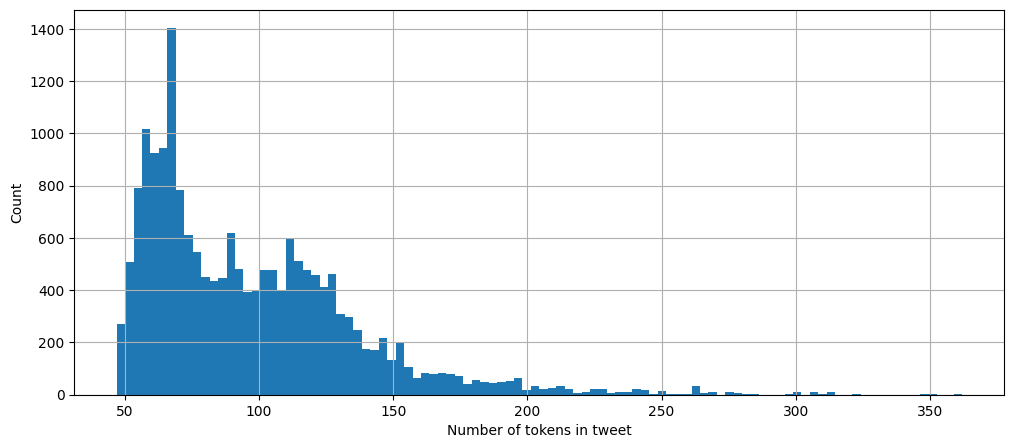

In [ ]:
# Plot the token distribution
plt.figure(figsize=(12,5))
plt.hist(twitter_df['token_count'], bins=100)
plt.grid(True)
plt.xlabel("Number of tokens in tweet")
plt.ylabel("Count")
plt.savefig(f'/content/drive/MyDrive/Thesis figures/twitter_char_count.png')

In [ ]:
# Drop the tweets with less than 60 tokens
twitter_df = twitter_df[twitter_df.token_count >= 60]
twitter_df.reset_index(inplace=True, drop=True)

In [ ]:
# Enrich the data with the stock price movement
twitter_df = stock_behaviour(twitter_df)

  0%|          | 0/15816 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()
/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


In [ ]:
# Check the balance between UP and DOWN in the dataset
balance_check(twitter_df)

1 trading day after the tweet the count for "UP" is  7811, and for down is 7683
2 trading day after the tweet the count for "UP" is  7839, and for down is 7655
3 trading day after the tweet the count for "UP" is  7981, and for down is 7513
4 trading day after the tweet the count for "UP" is  7988, and for down is 7506
5 trading day after the tweet the count for "UP" is  8220, and for down is 7274


In [ ]:
# Enrich the data with GPT-3.5-turbo relevance indications
twitter_df = OpenAI_relevance_check(twitter_df, 'tweet')

  0%|          | 0/15494 [00:00<?, ?it/s]

In [ ]:
twitter_df.to_json(f'/content/drive/MyDrive/Thesis data/cleaned_data/{filename_stamp}_twitter.json')

# News

In [ ]:
# Load the data from huggingface
dataset = load_dataset("edarchimbaud/news-stocks")
news_df = pd.DataFrame.from_dict(dataset['train'])
news_df.describe()

,symbol,body,publisher,publish_time,title,url,uuid
count,22025,22025,22025,22025,22025,22025,22025
unique,1476,18402,77,NaN,17721,18155,18088
top,AAPL,"Buying a stock is easy, but purchasing the rig...",Zacks,NaN,These Are The Best Robinhood Stocks To Buy Or ...,https://finance.yahoo.com/m/013f3a26-06d7-3bb6...,013f3a26-06d7-3bb6-8811-ddbc901f9eec
freq,96,22,6204,NaN,22,22,22
mean,NaN,NaN,NaN,2023-07-08 13:44:31.686882304+00:00,NaN,NaN,NaN
min,NaN,NaN,NaN,2022-12-01 21:15:00+00:00,NaN,NaN,NaN
25%,NaN,NaN,NaN,2023-06-02 17:01:00+00:00,NaN,NaN,NaN
50%,NaN,NaN,NaN,2023-06-20 14:45:00+00:00,NaN,NaN,NaN
75%,NaN,NaN,NaN,2023-07-14 13:38:00+00:00,NaN,NaN,NaN
max,NaN,NaN,NaN,2023-11-21 02:00:00+00:00,NaN,NaN,NaN


In [ ]:
# Rename columns to fit the twitter dataset convention
news_df = news_df.rename(columns = {'symbol':'ticker','body':'text','publish_time':'timestamp'})

In [ ]:
# Remove the particle articles
news_df['partial_article'] = news_df.text.str.contains('Continue reading') + news_df.text.str.contains('continue reading')
news_df = news_df[news_df['partial_article'] == False]
news_df.reset_index(inplace=True, drop=True)
news_df.count()

ticker             16659
text               16659
publisher          16659
timestamp          16659
title              16659
url                16659
uuid               16659
partial_article    16659
dtype: int64

In [ ]:
# Create prompts
news_df = create_prompt_and_tokenize(news_df, 'article')

  0%|          | 0/16659 [00:00<?, ?it/s]

  0%|          | 0/16659 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (6712 > 2048). Running this sequence through the model will result in indexing errors


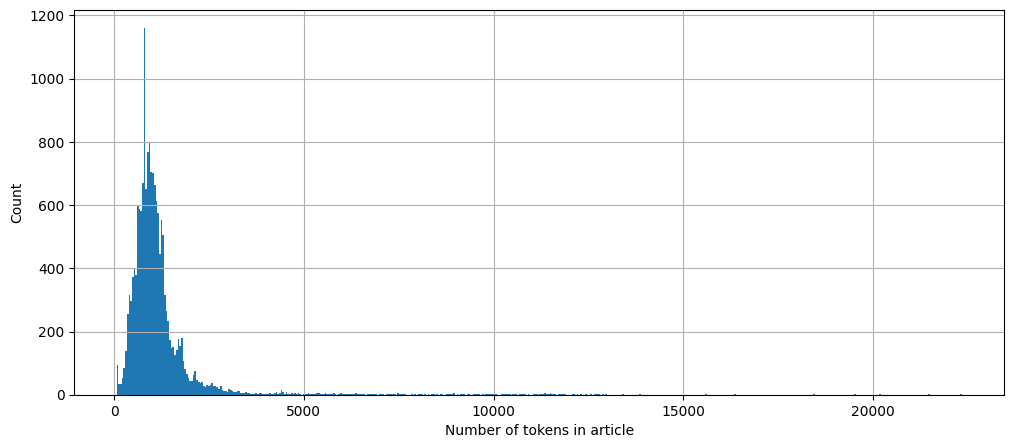

In [ ]:
# Plot the token distribution
plt.figure(figsize=(12,5))
plt.hist(news_df['token_count'], bins=500)
plt.grid(True)
plt.xlabel("Number of tokens in article")
plt.ylabel("Count")
plt.savefig(f'/content/drive/MyDrive/Thesis figures/news_char_count.png')

<Axes: >

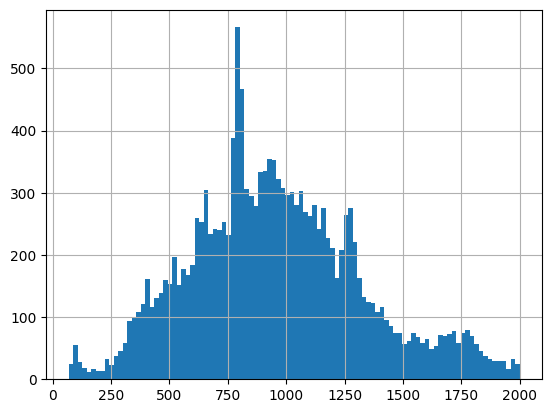

In [ ]:
# Drop articles with more than 2000 tokens
news_df = news_df[news_df['token_count'] < 2000]
news_df.reset_index(inplace=True, drop=True)

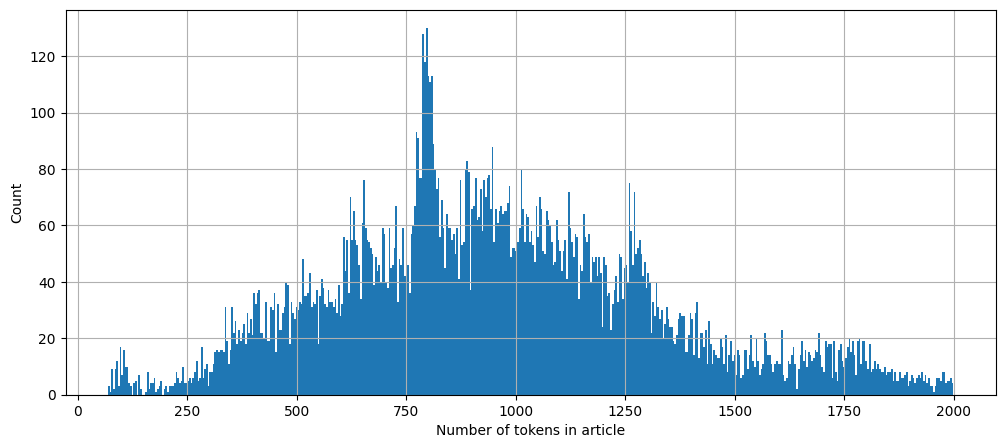

In [ ]:
# Plot the token distribution
plt.figure(figsize=(12,5))
plt.hist(news_df['token_count'], bins=500)
plt.grid(True)
plt.xlabel("Number of tokens in article")
plt.ylabel("Count")
plt.savefig(f'/content/drive/MyDrive/Thesis figures/news_char_count_2000.png')

<Axes: >

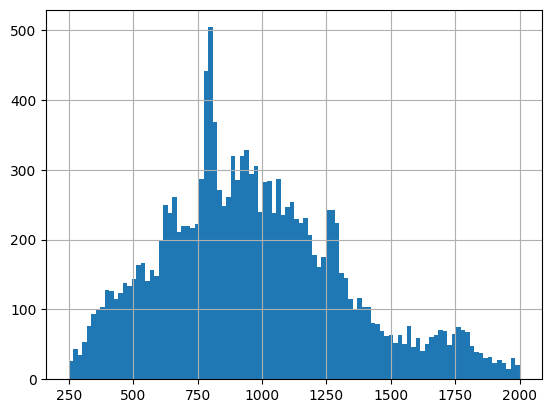

In [ ]:
# Remove the articles with less than 250 tokens
news_df = news_df[news_df['token_count'] >= 250]
news_df.reset_index(inplace=True, drop=True)

In [ ]:
news_df.count()

ticker             15204
text               15204
publisher          15204
timestamp          15204
title              15204
url                15204
uuid               15204
partial_article    15204
prompt             15204
token_count        15204
dtype: int64

In [ ]:
# Drop the tickers not known by yahoo_fin
news_df = remove_unknown_tickers(news_df)

  0%|          | 0/1351 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()
/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


  0%|          | 0/15204 [00:00<?, ?it/s]

In [ ]:
news_df.count()

ticker             15054
text               15054
publisher          15054
timestamp          15054
title              15054
url                15054
uuid               15054
partial_article    15054
prompt             15054
token_count        15054
valid_ticker       15054
dtype: int64

In [ ]:
# Enrich the data with the stock price movement
news_df = stock_behaviour(news_df)

  0%|          | 0/15054 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


In [ ]:
# Check the balance between UP and DOWN in the dataset
balance_check(news_df)

1 trading day after the tweet the count for "UP" is  7851, and for down is 7197
2 trading day after the tweet the count for "UP" is  8346, and for down is 6702
3 trading day after the tweet the count for "UP" is  8542, and for down is 6506
4 trading day after the tweet the count for "UP" is  8656, and for down is 6392
5 trading day after the tweet the count for "UP" is  8660, and for down is 6388


In [ ]:
news_df = OpenAI_relevance_check(news_df, 'article')

  0%|          | 0/15271 [00:00<?, ?it/s]

In [ ]:
news_df.to_json(f'/content/drive/MyDrive/Thesis data/cleaned_data/{filename_stamp}_news.json')
# News preprocessing ends here

# End colab session

In [ ]:
from google.colab import runtime
runtime.unassign()